In [31]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time

In [32]:
dim = 6

In [33]:
class RobotEnv(gym.Env):
    # observation represents the car's current position
    # reward is the value, either 1 (charging station) or 0 (not charging station); could add cracks or something later
    def __init__(self):
        super().__init__()
        # agent has 4 possible actions
        n_actions = 4
        # for a 10x10 grid
        n_states = dim*dim
        # define action space
        # next step: make it a continuous space
        self.action_space = gym.spaces.Discrete(n_actions)
        # define observation space
        self.observation_space = gym.spaces.Discrete(n_states)

        # check if reset
        self.if_reset = False
        
        # a 10x10 grid as the environment
        self.grid = np.zeros((dim,dim))

        # define initial position
        self.agent_position = (0,0)

        # define goal postion as upper opposite corner
        self.goal = (dim-1,dim-1) 

    def step(self, action):
        # change the agent's position depending on the input
        
        row = self.agent_position[0] # current row
        col = self.agent_position[1] # current col
        
        if action == 0: #UP
            if 0 <= row-1 < dim: # checking the boundary
                self.agent_position = (row-1,col)
            else:
                # position stays the same if the agent is at an edge
                self.agent_position = self.agent_position 
        elif action == 1: #DOWN
            if 0 <= row+1 < dim:
                self.agent_position = (row+1,col)
            else:
                self.agent_position = self.agent_position                
        elif action == 2: #LEFT
            if 0 <= col-1 < dim:
                self.agent_position = (row,col-1)
            else:
                self.agent_position = self.agent_position                
        elif action == 3: #RIGHT
            if 0 <= col+1 < dim:
                self.agent_position = (row,col+1)
            else:
                self.agent_position = self.agent_position
        
        # observation is the agent's position on the grid, from 0 to 99
        observation = self.agent_position[0]*10 + self.agent_position[1]

        # reward function based on the value of the agent's position
        reward = observation +1
        '''
        if observation == 99:
            reward = 100
        elif observation % 2 == 0:
            reward = 20
        else:
            reward = 30'
        '''
        
        # task is complete if the agent reaches the goal
        terminated = None
        if self.agent_position == self.goal:
            terminated = True

        return observation, reward, terminated, False, {}
    
    def reset(self):
        # reset agent to initial position
        self.agent_position = (0,0)
        # define goal postion 
        self.goal = (dim-1,dim-1)
        # get initial observation
        observation = self.agent_position[0]*10 + self.agent_position[1]
    
        return observation, {}
    
    def render(self):
        self.grid = np.zeros((dim,dim))
        self.grid[self.goal] = 99

        # point values for visualization
        
        # trying to teach the agent a spiral pattern

        # agent position value for visualization
        self.grid[self.agent_position] = 50

        return self.grid

    def close(self):
        pass

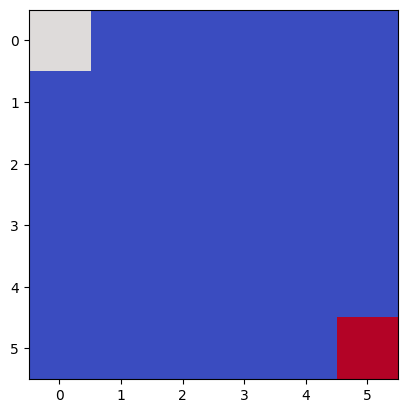

In [34]:
env = RobotEnv()
env.reset()
plt.imshow(env.render(),cmap='coolwarm')

In [35]:
def select_action(q_table, state, epsilon, action_space):
    if np.random.rand() > epsilon:
        # exploitation uses q table to choose action
        action = q_table[state, :].argmax()
    else:
        # exploration is random
        action = np.random.randint(4)
    return action

In [36]:
def q_learning(epsilon,eps_decay,min_epsilon,gamma,action_space,rewards):
    q_table = np.zeros((100,4))
    actions = ['up', 'down', 'left', 'right'] 
    # reset the environment
    state, _ = env.reset()
    learning_rate = 0.5

    for t in range(50000):
        # select action
        action = select_action(q_table, state,  epsilon, action_space)
        next_state, reward, terminated, truncated, info = env.step(action)
        # update q table
        q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
                                learning_rate * (reward + (gamma * q_table[next_state, :].max()))
        # update rewards list
        rewards.append(reward)
        state = next_state
        # update epsilon if decay is used
        epsilon = np.max([epsilon - eps_decay, min_epsilon])
    
    return q_table, rewards

In [37]:
q_tableD, rewardsD = q_learning(0.99,0.001,0.1,0.8,4,[])

Text(0.5, 1.0, 'Epsilon=0.99, Decay=0.001, Gamma=0.9')

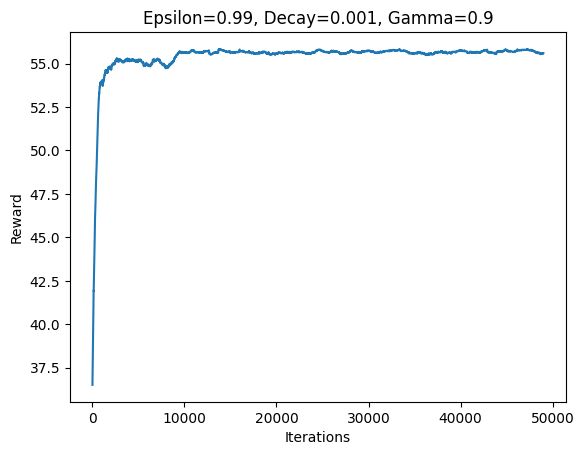

In [38]:
T = 1000
reward_conv1 =  np.convolve(np.array(rewardsD), np.ones(T), mode="valid") / T
fig, ax = plt.subplots()
ax.plot(reward_conv1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Reward')
ax.set_title('Epsilon=0.99, Decay=0.001, Gamma=0.9')

In [39]:
q_tableD

array([[ 15.47125562,  38.18830134,  17.33636125,   3.30192   ],
       [  3.30192   ,  17.91856896,  21.92344172,  14.02108512],
       [ 26.05344991,  44.91961492,  13.72843427,  17.98698996],
       [ 17.59060277,   0.        ,  31.02429778,   4.60613002],
       [  0.        ,  30.0965131 ,   5.26532506,   0.        ],
       [ 18.47295488,  47.94724186,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 15.08573725,  43.97594428,  20.1480328 ,  28.44884629],
       [ 13.48936138,   0.        ,  20.2851184 ,  40.0626456 ],
       [ 36.36568518,  49.30818566,  31.96731029,  19.73027733],
       [  2.        ,   0.        ,  34.61354   ,   7.5       ],
       [  7.15      ,  24.56389555,  10.        ,  84.07818831],
       [ 19.22295488, 144

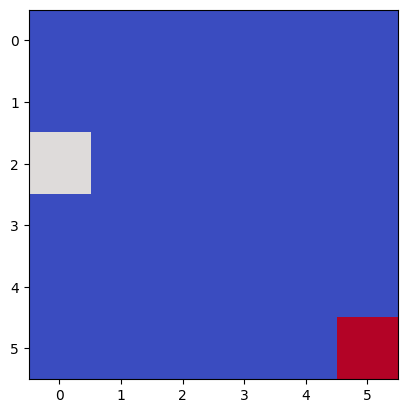

In [40]:
state, _ = env.reset()
actions = ['up', 'down', 'left','right' ] 
path = []

for t in range(100):
    action = q_tableD[state, :].argmax()
    path.append((env.agent_position,actions[action]))

    next_state, reward, terminated, truncated, info = env.step(action)
    state = next_state
    plt.imshow(env.render(),cmap='coolwarm')
    
    if terminated:
        path.append((env.agent_position,actions[action]))
        state, _ = env.reset()
        break

In [41]:
path

[((0, 0), 'down'),
 ((1, 0), 'down'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'left'),
 ((2, 0), 'l

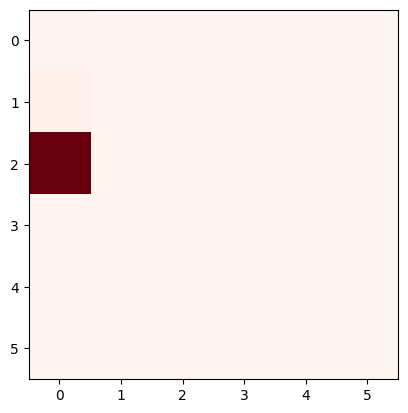

In [42]:
grid = np.zeros((dim,dim))
for i in range(len(path)):
    grid[path[i][0]] = i+1
plt.imshow(grid,cmap='Reds')

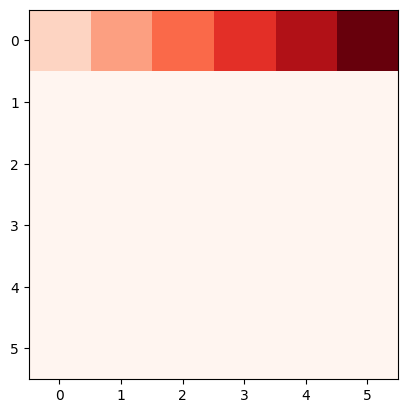

In [43]:
path = []
# if row number is odd, go right, otherwise go left
# if end of row, go down
for i in range(dim):
    path.append(((0,i),'right'))
path.append(((1,dim),'down'))
for i in range(dim):
    path.append(((1,i),'left'))

grid = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        grid[path[i][0]] = i+1

plt.imshow(grid,cmap='Reds')

In [44]:
path

[((0, 0), 'right'),
 ((0, 1), 'right'),
 ((0, 2), 'right'),
 ((0, 3), 'right'),
 ((0, 4), 'right'),
 ((0, 5), 'right'),
 ((1, 6), 'down'),
 ((1, 0), 'left'),
 ((1, 1), 'left'),
 ((1, 2), 'left'),
 ((1, 3), 'left'),
 ((1, 4), 'left'),
 ((1, 5), 'left')]

In [45]:
len(path)%dim

1

In [ ]:
pos = (0,0) # initial position
obs = pos[0]*dim+pos[1] #position as a number from 0 to dim
row = pos[0] # current row
col = pos[1] # current col
charged = False
# iterate over the whole grid (rows, columns for each row)
# take observation and decide what to do
# if row # is odd, go right; if even, go left
# if edge, go down
# if specific square for the first time, go back up, then back down

